# Node equivalence with Node2Vec

Node2Vec is an algorithm designed for detecting structural equivalence and segments of a graph.

In this notebook, the Leviticus-network will be explored with Node2Vec in a progression of complexity, according to the following criteria:
1. The network as a directed but unweighted graph
2. The network as a multiple directed graph (weights)
3. The network as a multiple directed graph (weighted by average agency values)

**Other tutorials**
* https://towardsdatascience.com/node2vec-embeddings-for-graph-data-32a866340fef
* https://medium.com/neo4j/machine-learning-on-graphs-fca6eeb8f1d1
* https://www.kaggle.com/ferdzso/knowledge-graph-analysis-with-node2vec
* https://www.kaggle.com/pierremegret/gensim-word2vec-tutorial

In [1]:
import collections

import networkx as nx
from node2vec import Node2Vec
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.manifold import MDS

#### Import data

In [38]:
data = pd.read_excel('Lev17-26.edges.Static.xlsx')
data.head()

,Source,Source_label,Source_agency,Target,Target_label,Target_agency,Label,Weight,Type,Clause
0,49,Aaron's_sons,5,43,YHWH,0,swing,25,Directed,440323
1,43,YHWH,5,39,Moses,-1,speak,36,Directed,440335
2,53,Israelites,5,43,YHWH,-1,approach,36,Directed,440341
3,43,YHWH,5,39,Moses,-1,speak,36,Directed,440342
4,53,Israelites,5,43,YHWH,-1,approach,36,Directed,440347


## 1. Simple, directed graph

In [39]:
G = nx.DiGraph()

for n, row in data.iterrows():
    G.add_edge(row.Source_label, row.Target_label)

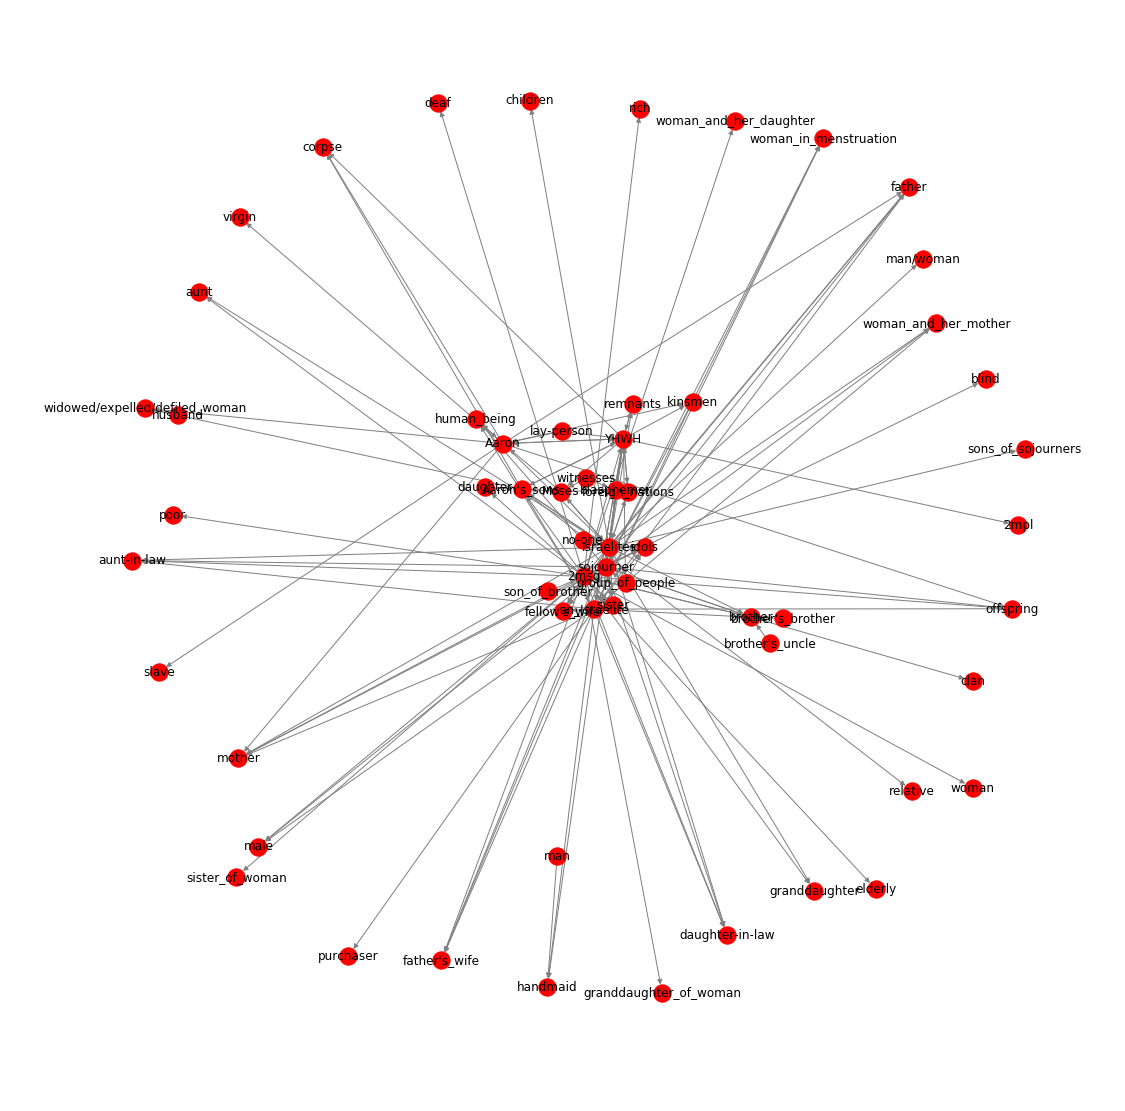

In [40]:
plt.figure(figsize = (15,15))

nx.draw(
    G,
    pos=nx.spring_layout(G),
    with_labels=True,
    edge_color='grey'
    )

plt.show()

We define a few global measures to account for in all examples:

In [41]:
dim = 16
wl = 4
nw = 150
p=1
q=1

In [42]:
node2vec = Node2Vec(G, dimensions=dim, walk_length=wl, num_walks=nw, p=p, q=q)

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 150/150 [00:00<00:00, 288.96it/s]


Definitions:
* window (size) = the maximum distance between the current and the predicted node in the vector
* min_count = ignores all words with total absolute frequency lower than this

In [43]:
model = node2vec.fit(window=6, min_count=1)

In [44]:
model.wv.save_word2vec_format('node2vec/simple_directed')

### Clustering embeddings

In [45]:
def getEmbeddings(file, nodes):
    with open(file) as f:
        mylist = [line.rstrip('\n') for line in f]

    embeddings_dict = collections.defaultdict()
    for l in mylist[1:]:
        vector = l.split()
        embeddings_dict[vector[0]] = vector[1:]

    """Extract representations from the node2vec model"""
    embeddings = [embeddings_dict[str(n)] for n in nodes]
    embeddings = np.array(embeddings)
    return embeddings

#### How many clusters?

The more clusters, the less the distance is between the centroid and its members. This is measured with WCSS ("within-cluster sum of squares").

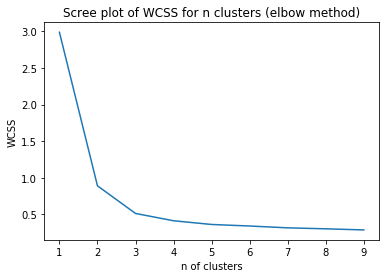

In [46]:
X = getEmbeddings('node2vec/simple_directed', G.nodes())

def elbow(X,max_clusters=10):

    wcss = [] #for storing the intertia property

    for i in range(1, max_clusters):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    plt.plot(range(1, max_clusters), wcss)
    plt.title('Scree plot of WCSS for n clusters (elbow method)')
    plt.xlabel('n of clusters')
    plt.ylabel('WCSS')
    plt.show()
    
elbow(X)

In [47]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter=300, n_init=10, random_state=0).fit(X)

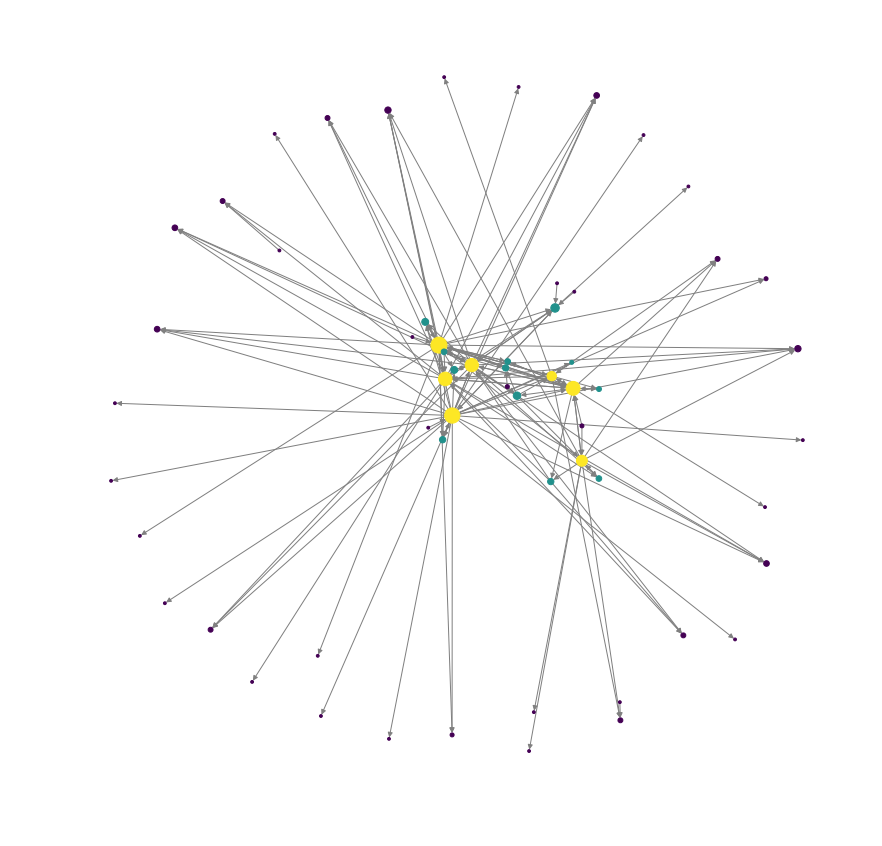

In [48]:
def draw(graph, X, kmeans, labels=True, size=(15,15)):

    plt.figure(figsize = size)
    
    nx.draw_networkx(
        graph,
        pos=nx.spring_layout(graph),
        with_labels=labels,
        node_size=[n[1]*8 for n in G.degree()],
        node_color=kmeans.labels_,
        edge_color='grey'
        )
    
    plt.axis('off')
    plt.show()
    
draw(G, X, kmeans, labels=False)

C:\Users\Ejer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:563: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)


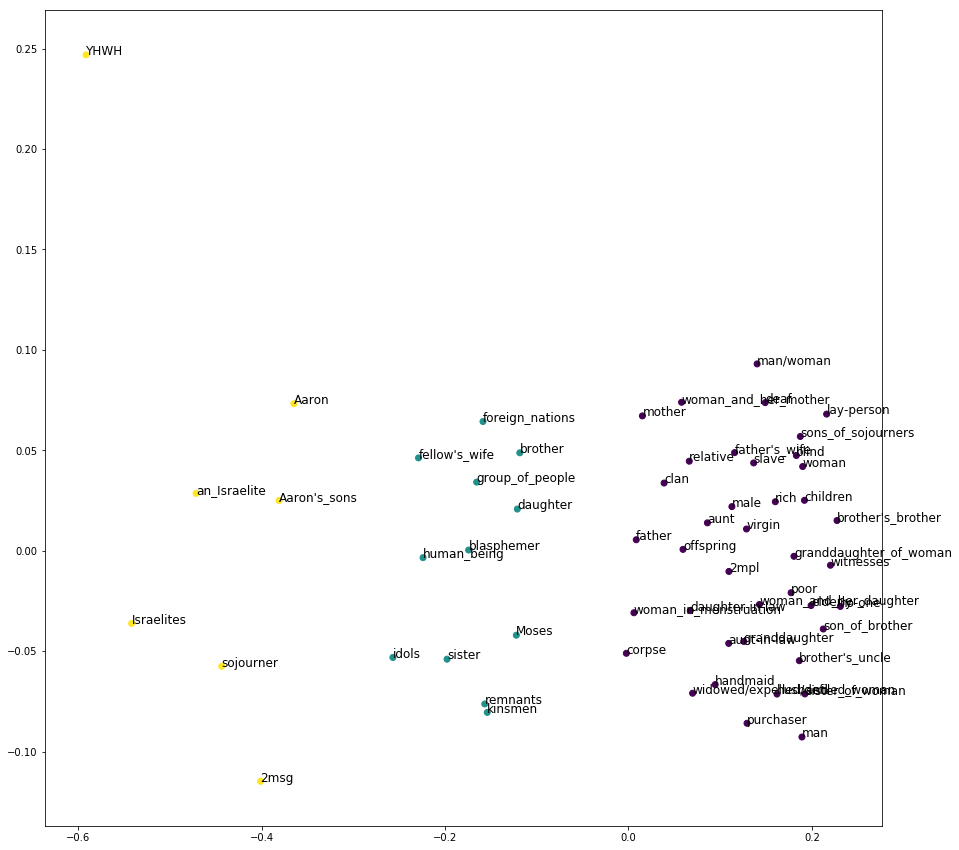

In [49]:
def mds(graph, X, kmeans, n_components=2, label=True, size=(7,7)):
    embedding = MDS(n_components=2)
    X_transformed = embedding.fit_transform(X)
    X = pd.DataFrame(X_transformed, index=graph.nodes)
    
    plt.figure(figsize=size)
    plt.scatter(X.iloc[:,0],X.iloc[:,1], c=kmeans.labels_)

    if label:
        for n, row in X.iterrows():
            plt.text(row[0],row[1],n, size=12)

    plt.xticks()
    plt.show()
    
mds(G, X, kmeans, size=(15,15))

## 2. Multiple directed graph

In [50]:
G = nx.MultiDiGraph()

for n, row in data.iterrows():
    G.add_edge(row.Source_label, row.Target_label)

In [51]:
node2vec = Node2Vec(G, dimensions=dim, walk_length=wl, num_walks=nw, p=p, q=q)

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 150/150 [00:00<00:00, 301.64it/s]


In [52]:
model = node2vec.fit(window=10, min_count=1)

In [53]:
model.wv.save_word2vec_format('node2vec/multiple_directed')

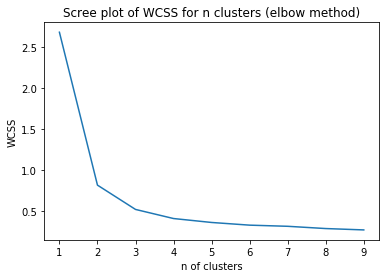

In [54]:
X = getEmbeddings('node2vec/multiple_directed', G.nodes())
    
elbow(X)

In [55]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter=300, n_init=10, random_state=0).fit(X)

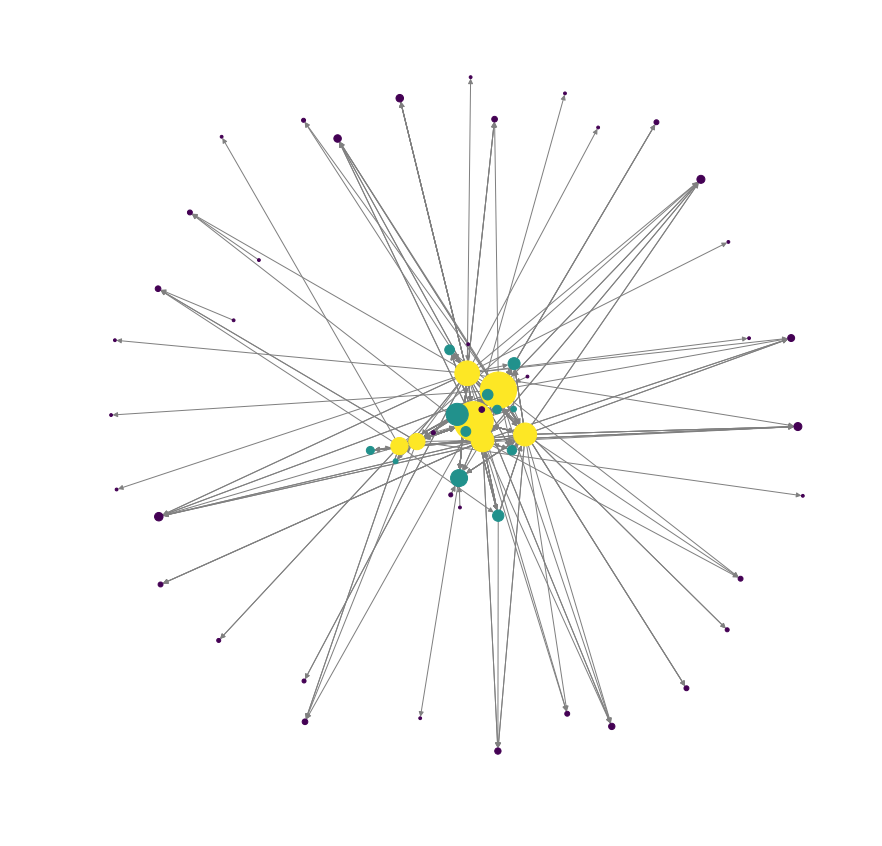

In [56]:
draw(G, X, kmeans, labels=False)

C:\Users\Ejer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:563: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)


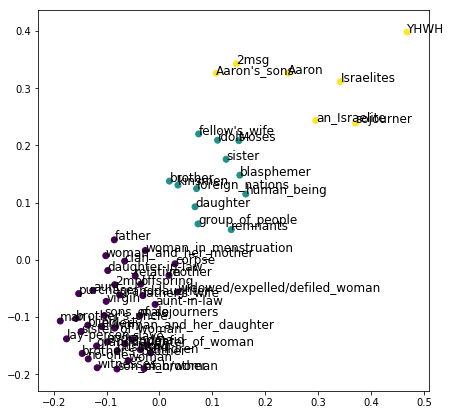

In [57]:
mds(G, X, kmeans)

## 3. Multiple directed and valued ties

In [72]:
G = nx.MultiDiGraph()

for n, row in data.iterrows():
    G.add_edge(row.Source_label, row.Target_label, value=row.Weight)
    
nodes = list(G.nodes())

In [73]:
node2vec = Node2Vec(G, dimensions=dim, walk_length=wl, num_walks=nw, p=p, q=q, weight_key='value')

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 150/150 [00:00<00:00, 342.57it/s]


In [74]:
model = node2vec.fit(window=6, min_count=1)

In [75]:
model.wv.save_word2vec_format('node2vec/multiple_valued_directed')

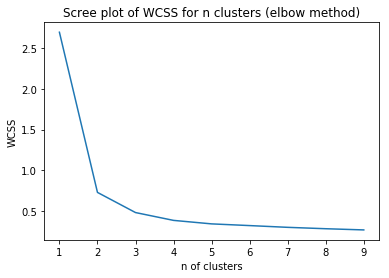

In [76]:
X = getEmbeddings('node2vec/multiple_valued_directed', G.nodes())
    
elbow(X)

In [77]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter=300, n_init=10, random_state=0).fit(X)

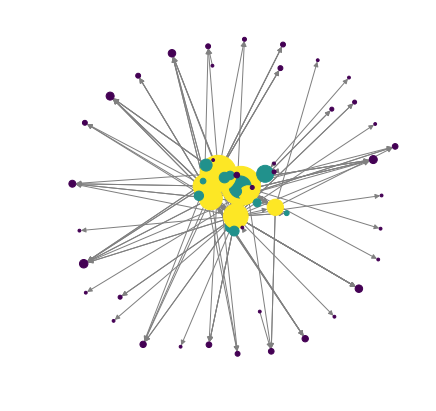

In [78]:
draw(G, X, kmeans, labels=False, size=(7,7))

C:\Users\Ejer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:563: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)


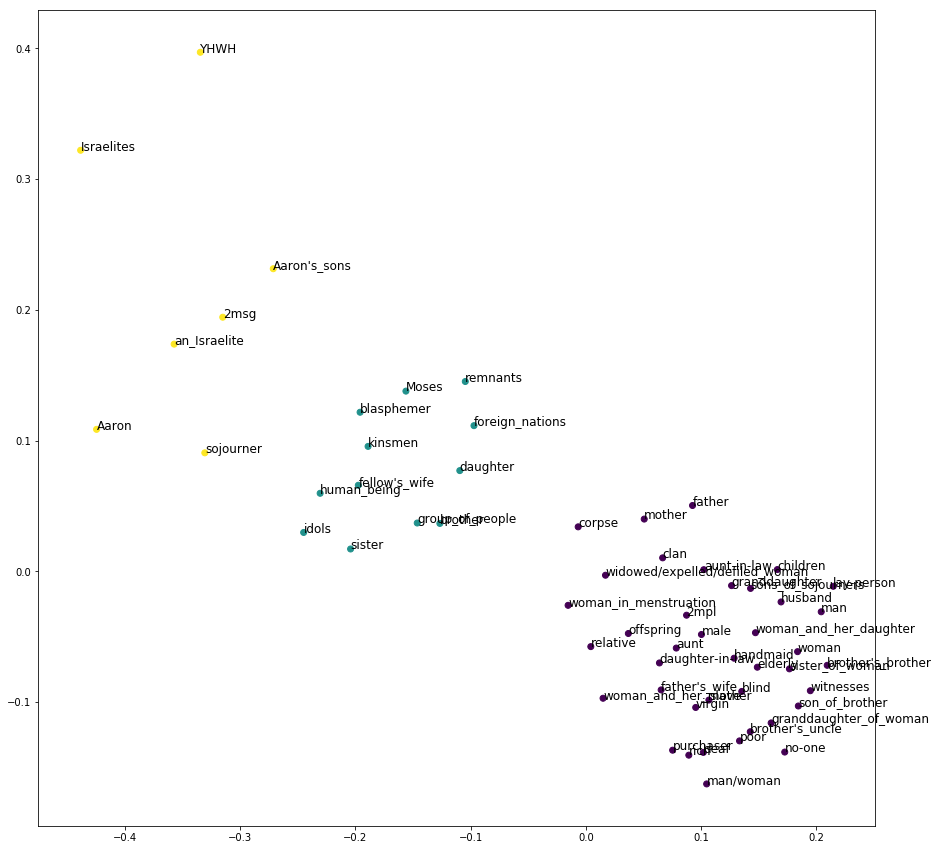

In [82]:
mds(G, X, kmeans, size=(15,15))

In [66]:
list(G.nodes())

["Aaron's_sons",
 'YHWH',
 'Moses',
 'Israelites',
 'kinsmen',
 'an_Israelite',
 'Aaron',
 'blasphemer',
 'sojourner',
 '2msg',
 'corpse',
 'foreign_nations',
 'remnants',
 'group_of_people',
 '2mpl',
 'lay-person',
 'witnesses',
 'father',
 'mother',
 'virgin',
 'widowed/expelled/defiled_woman',
 'offspring',
 'human_being',
 'slave',
 'brother',
 'handmaid',
 'sons_of_sojourners',
 'children',
 'no-one',
 'idols',
 "father's_wife",
 'sister',
 'aunt',
 'aunt-in-law',
 'daughter-in-law',
 "fellow's_wife",
 'granddaughter',
 'woman_and_her_mother',
 'man/woman',
 'male',
 'woman_in_menstruation',
 'purchaser',
 'relative',
 'daughter',
 'deaf',
 'blind',
 'poor',
 'rich',
 'elderly',
 'woman',
 'son_of_brother',
 'woman_and_her_daughter',
 'granddaughter_of_woman',
 'sister_of_woman',
 "brother's_brother",
 'clan',
 "brother's_uncle",
 'man',
 'husband']

In [67]:
cluster_dict = {}

for n in range(len(G.nodes())):
    cluster_dict[list(G.nodes())[n]] = kmeans.labels_[n]

cluster_df = pd.DataFrame([cluster_dict]).T
cluster_df.columns = ['cluster']

cluster_df.to_csv('node2vec/multiple_directed_valued_clusters.csv')

### Contrasting the sojourner and the Israelites

The sojourner is a curious participant in the network. On the hand, Leviticus 17-26 gives the impression that the sojourner is generally a person on the margins of society. However, in the network, he is situated safely at the core of the network. The network may be misleading because the native Israelites are distinguished as the collective group ("Israelites"), an individual Israelite addressee ("2ms") and an individual, third-person Israelite ("an_Israelite"). Of course, many other participants (e.g. the mother and the father) also belong to the Israelites as an ethnic category. In the text, however, they are not so much distinguished in terms of ethnicitiy as in terms of social role. Therefore, these other roles will be retained. The first three, however, will be merged into a single role in order to explore the role of the sojourner in contrast to Israelites:

In [68]:
G1 = nx.contracted_nodes(G, "Israelites", "2ms")
G1 = nx.contracted_nodes(G1, "Israelites", "an_Israelite")

KeyError: '2ms'

In [ ]:
node2vec = Node2Vec(G1, dimensions=dim, walk_length=wl, num_walks=nw, p=p, q=q, weight_key='value')

In [ ]:
model = node2vec.fit(window=6, min_count=1)

In [ ]:
model.wv.save_word2vec_format('multiple_valued_directed_Israelites')

In [ ]:
X = getEmbeddings('multiple_valued_directed_Israelites', G1.nodes())

def elbow(X,max_clusters=10):

    wcss = [] #for storing the intertia property

    for i in range(1, max_clusters):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)

    plt.plot(range(1, max_clusters), wcss)
    plt.title('Scree plot of WCSS for n clusters (elbow method)')
    plt.xlabel('n of clusters')
    plt.ylabel('WCSS')
    plt.show()
    
elbow(X)

In [ ]:
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter=300, n_init=10, random_state=0).fit(X)

In [ ]:
draw(G1, X, kmeans, labels=False, size=(15,15))

C:\Users\Ejer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:563: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)


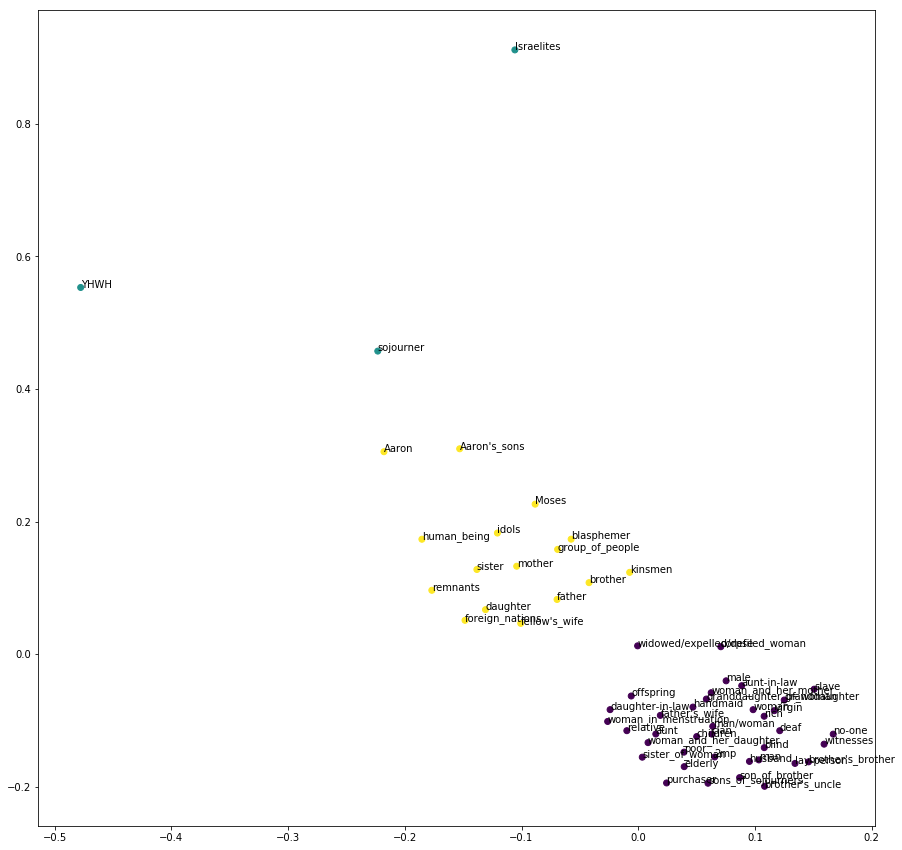

In [44]:
mds(G1, X, kmeans, size=(15,15))

### Case study: Diachronic change

#### Splitting the dataset

In [54]:
from tf.app import use
A = use('bhsa', hoist=globals(), silent=True)

   |     0.00s No structure info in otext, the structure part of the T-API cannot be used


In [50]:
phase1 = ((17,1),(24,23))
phase2 = ((25,1),(26,46))

def getClauses(phase, df=data, book='Leviticus'):
    
    first_clause = L.d(T.nodeFromSection((book, phase[0][0], phase[0][1])), 'clause')[0]
    last_clause = L.d(T.nodeFromSection((book, phase[1][0], phase[1][1])), 'clause')[-1]
    
    return range(first_clause, last_clause+1)

phase1_cl = getClauses(phase1)
phase2_cl = getClauses(phase2)

In [51]:
df1 = data[data.Clause.isin(list(phase1_cl))]
df2 = data[data.Clause.isin(list(phase2_cl))]

Are all clauses included?

In [53]:
len(data)-(len(df1)+len(df2))

0

#### Node2Vec applied to each phase

In [56]:
def Graph(df):

    G = nx.MultiDiGraph()

    for n, row in df.iterrows():
        G.add_edge(row.Source_label, row.Target_label, value=row.Weight)

    return G

graph1 = Graph(df1)
graph2 = Graph(df2)

In [57]:
#Model phase 1
node2vec = Node2Vec(graph1, dimensions=dim, walk_length=wl, num_walks=nw, p=p, q=q, weight_key='value')
model = node2vec.fit(window=6, min_count=1)
model.wv.save_word2vec_format('multiple_valued_directed_phase1')

#Model phase2
node2vec = Node2Vec(graph2, dimensions=dim, walk_length=wl, num_walks=nw, p=p, q=q, weight_key='value')
model = node2vec.fit(window=6, min_count=1)
model.wv.save_word2vec_format('multiple_valued_directed_phase2')

Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 150/150 [00:00<00:00, 583.70it/s]


Phase 1:

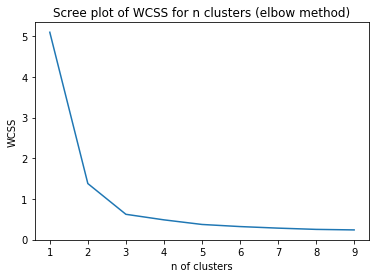

In [62]:
embeddings1 = getEmbeddings('multiple_valued_directed_phase1', graph1.nodes())
elbow(embeddings1)

In [69]:
kmeans_graph1 = KMeans(n_clusters = 3, init = 'k-means++', max_iter=300, n_init=10, random_state=0).fit(embeddings1)

C:\Users\Ejer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:563: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)


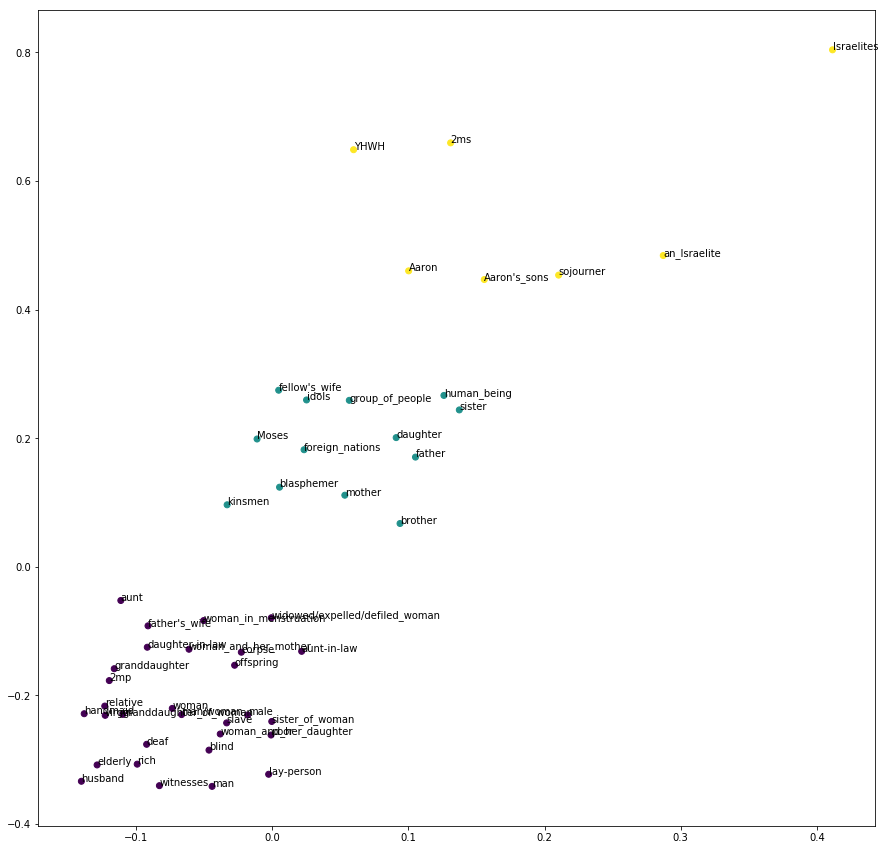

In [70]:
mds(graph1, embeddings1, kmeans_graph1, size=(15,15))

Phase 2:

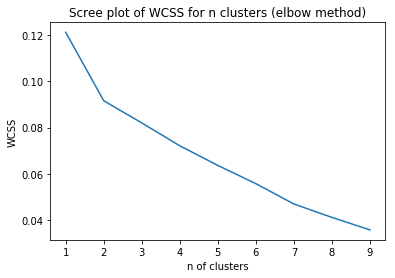

In [68]:
embeddings2 = getEmbeddings('multiple_valued_directed_phase2', graph2.nodes())
elbow(embeddings2)

In [73]:
kmeans_graph2 = KMeans(n_clusters = 2, init = 'k-means++', max_iter=300, n_init=10, random_state=0).fit(embeddings2)

C:\Users\Ejer\Anaconda3\lib\site-packages\sklearn\utils\validation.py:563: FutureWarning: Beginning in version 0.22, arrays of bytes/strings will be converted to decimal numbers if dtype='numeric'. It is recommended that you convert the array to a float dtype before using it in scikit-learn, for example by using your_array = your_array.astype(np.float64).
  FutureWarning)


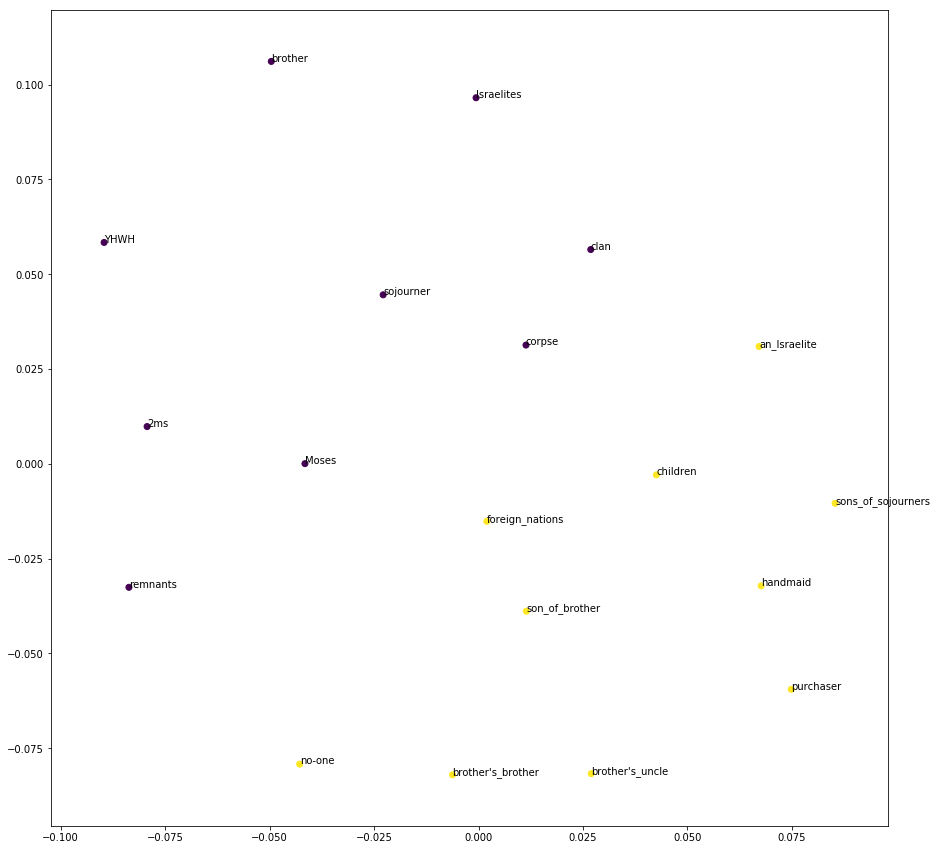

In [74]:
mds(graph2, embeddings2, kmeans_graph2, size=(15,15))

### Export clusters

In [83]:
kmeans_clusters = pd.DataFrame([nodes, list(kmeans.labels_)]).T
kmeans_clusters.columns = ['node','cluster']
kmeans_clusters.head()

,node,cluster
0,Aaron's_sons,2
1,YHWH,2
2,Moses,1
3,Israelites,2
4,kinsmen,1


In [85]:
kmeans_clusters.to_csv('node2vec/multiple_directed_valued_clusters.csv')